In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [11]:
# Useful constant
# 1/MeV to cm
to_cm = 1.973e-11
# 1/MeV^2 to cm^2
to_cm2 = to_cm**2
# electron mass in MeV
me = 0.511
# tau mass in MeV
mtau = 1776.86
# mu mass in MeV
mmu = 105.658
# gram to MeV
g2MeV = 1/(1.783e-27)
# 1/s to MeV
s2MeV = 6.529e-22
# Fine structure constant for EM interaction
alphaEM = 1/137
# Electric charge squared
eSquared = 4*np.pi*alphaEM

In [118]:
def amplitudeSquared(s,t,u,m1,m2,mV):
    """
    The spin-averaged amplitude squared for vector interactio
    
    Input
    ------
    s: Mandelstam variables s
    t: Mandelstam variables t
    u: Mandelstam variables u
    m1: Mass of incoming particle 1
    m2: Mass of particle 2 to be scattered off
    mV: Mediator mass
    
    Output
    ------
    scalar: spin-averaged amplitude squared
    """
    # Define sum over mass squared
    massSum = m1**2 + m2**2
    # Spin-averaged amplitude-squared
    ampSq = 2/(t - mV**2)**2*(s**2 + u**2 + 4*t*massSum - 2*massSum**2)
    return ampSq


def getMomentum(m,T):
    """
    Get the momentum of particle with mass m and kinetic energy T
    
    Input
    ------
    m: Mass of the particle
    T: Kinetic energy of the particle
    
    Output
    ------
    scalar: The associated particle momentum
    """
    return np.sqrt(T*(T + 2*m))


def getVelocity(m,T):
    """
    Get the velocity of particle with mass m and kinetic energy T
    
    Input
    ------
    m: Mass of the particle
    T: Kinetic energy of the particle
    
    Output
    ------
    scalar: The associated dimensionless particle velocity
    """
    return getMomentum(m,T)/(T + m)


def getEv(mx,Tx,psi):
    """
    Get the required neutrino energy to boost DM up with kinetic
    energy Tx at angle psi
    
    Input
    ------
    mx: Mass of DM
    Tx: BDM kinetic energy
    psi: Scattering angle
    
    Output
    ------
    Ev: The requires neutrino energy. If the resulting Ev is negative,
        then it is unphysical
    """
    px = getMomentum(mx,Tx)
    return -mx*Tx/(Tx - px*np.cos(psi))


def dEv(mx,Tx,psi):
    """
    Get the dEv/dTx
    
    Input
    ------
    mx: Mass of DM
    Tx: BDM kinetic energy
    psi: Scattering angle
    
    Output
    ------
    scalar: dEv/dTx
    """
    px = getMomentum(mx,Tx)
    x = np.cos(psi)
    return mx**2*Tx*x/(Tx - px*x)**2
    

def stuLab(m2,T,psi):
    """
    The Mandelstam variables s, t and u in lab frame for massless
    incoming particle 1 and massive particle 2 at rest in the beginning
    
    Input
    ------
    m2: Mass of particle 2 to be scattered off
    T: The kinetic energy received by m2 after scattering
    psi: The scattering angle of m2 with respect to the incoming particle 1
    
    Output
    ------
    tup: (s,t,u)
    """
    p = getMomentum(m2,T)
    x = np.cos(psi)
    s = m2**2*(p*x + T)/(p*x - T)
    t = -2*m2*T
    u = m2**2 - t*(1 + m2/(T - p*x))
    return s,t,u


def maxPsi(mx,Tx):
    """
    Get the maximumly allowed scattering angle psi
    
    Input
    ------
    mx: Mass of DM
    Tx: BDM kinetic energy
    
    Output
    ------
    psi: maximum psi allowed to have physical Ev, in rad
    """
    maxCosValue = np.sqrt(Tx/(Tx + 2*mx))
    return np.arccos(maxCosValue)


def diffCrossSectionNuDM(mx,mV,Tx,psi,gV,gD):
    """
    Get the differential Nu-DM scattering cross section over psi
    
    Input
    ------
    mx: Mass of DM
    mV: Mediator mass
    Tx: BDM kinetic energy
    psi: Scattering angle
    gV: The coupling strength for V-Nu-Nu vertex
    gD: The coupling strength for V-DM-DM vertex
    
    Output
    ------
    scalar: differential cross section, cm^2 per rad
    """
    if psi < maxPsi(mx,Tx):
        # Get the Mandelstam variables
        s,t,u = stuLab(mx,Tx,psi)
        # Get the amplitude squared
        ampSq = amplitudeSquared(s,t,u,0,mx,mV)
        # Differential cross section
        diffCrox = (gV*gD)**2*ampSq*np.sqrt((1/mx + 2/Tx)/mx**3)*np.sin(psi)*to_cm2
    else:
        diffCrox = 0
    return diffCrox


def kallenLambda(x,y,z):
    return x**2 + y**2 + z**2 - 2*(x*y + y*z + z*x)


def totalCrossSectionDMe(mx,mV,Tx,eps,gD):
    """
    Get the total DM-electron scattering cross section
    
    Input
    ------
    mx: Mass of DM
    mV: Mediator mass
    Tx: BDM kinetic energy
    eps: The coupling strength for V-e-e vertex
    gD: The coupling strength for V-DM-DM vertex
    
    Output
    ------
    scalar: total cross section, cm^2
    """
    s = mx**2 + me**2 + 2*(mx + Tx)*me 
    ExSq = (s + mx**2 - me**2)**2/4/s    # Ex^2
    pSq = (s - (mx + me)**2)*(s - (mx - me)**2)/4/s    # p^2
    
    # Define the d\sigma/dt
    def _dsig(t):
        u = 2*(mx**2 + me**2) - s - t
        return to_cm2*amplitudeSquared(s,t,u,mx,me,mV)
    
    # Define the integration range
    tm = 2*mx**2 - 2*(ExSq + pSq)
    tp = 2*mx**2 - 2*(ExSq - pSq)
    # Evaluating the integral \int dt*d\sigma/dt
    totCrox,_ = quad(_dsig,tm,tp)
    return totCrox*(gD*eps)**2**eSquared/64/np.pi/s/pSq

In [119]:
mx_ls = np.logspace(-5,1,100)
Tx = 100
sig_xe_ls = []
for mx in mx_ls:
    sig_xe_ls.append(totalCrossSectionDMe(mx,mx/3,Tx,1,1))

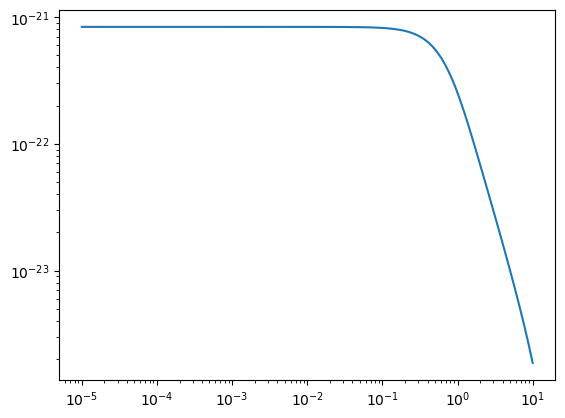

In [120]:
plt.plot(mx_ls,sig_xe_ls)
plt.xscale('log')
plt.yscale('log')

In [68]:
mx = 0.1
Tx = 10
mV = mx/3
psi_ls = np.logspace(-5,np.log10(maxPsi(mx,Tx)),100)
crox_ls = []
Ev_ls = []
dEvdTx_ls = []
for psi in psi_ls:
    Ev = getEv(mx,Tx,psi)
    crox_ls.append(diffCrossSectionNuDM(mx,mV,Tx,psi,1,1)*dEv(mx,Tx,psi)*Ev**2/(np.exp(Ev)+1))
    Ev_ls.append(Ev)
    dEvdTx_ls.append(dEv(mx,Tx,psi))

/var/folders/qf/n6502vwn5yz_j_q3fyn7nt140000gn/T/ipykernel_43875/1721939418.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  return -mx*Tx/(Tx - px*np.cos(psi))
/var/folders/qf/n6502vwn5yz_j_q3fyn7nt140000gn/T/ipykernel_43875/1721939418.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  return mx**2*Tx*x/(Tx - px*x)**2
/var/folders/qf/n6502vwn5yz_j_q3fyn7nt140000gn/T/ipykernel_43875/4145442203.py:10: RuntimeWarning: invalid value encountered in double_scalars
  crox_ls.append(diffCrossSectionNuDM(mx,mV,Tx,psi,1,1)*dEv(mx,Tx,psi)*Ev**2/(np.exp(Ev)+1))


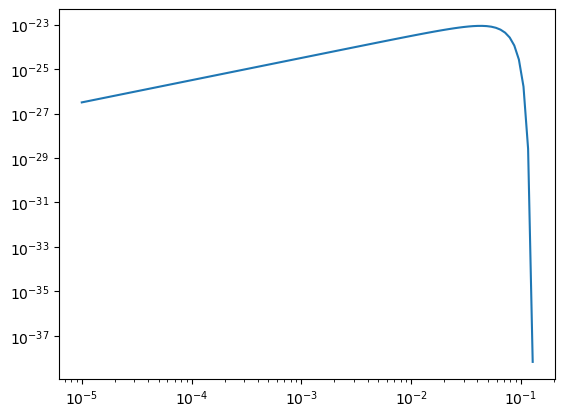

In [69]:
plt.plot(psi_ls,crox_ls)
plt.xscale('log')
plt.yscale('log')

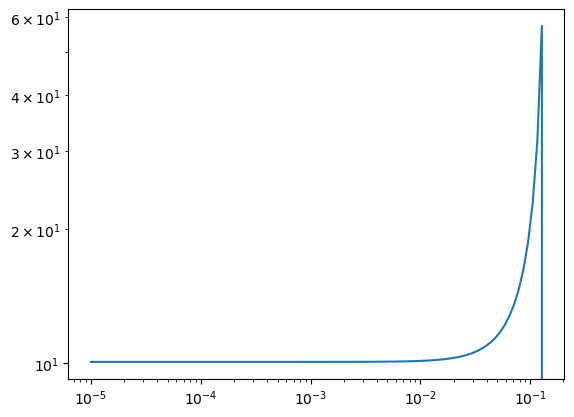

In [58]:
plt.plot(psi_ls,Ev_ls)
plt.xscale('log')
plt.yscale('log')

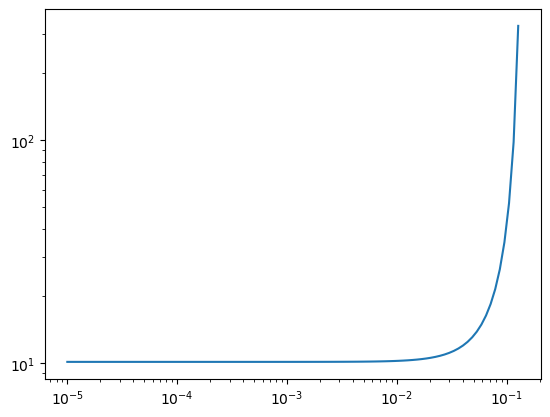

In [62]:
plt.plot(psi_ls,dEvdTx_ls)
plt.xscale('log')
plt.yscale('log')

In [66]:
dEv(mx,Tx,0.1)

41.357670369729895

In [48]:
np.arccos(0.5)

1.0471975511965976

In [50]:
np.cos(0.3)

0.955336489125606

In [123]:
maxPsi(1,5)

0.5639426413606289

In [124]:
maxPsi(1,100)

0.1404897017535205